In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Webscrapping Imports
from bs4 import BeautifulSoup       
import regex as re

# NLP Imports
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import nltk


# Modelling Imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# Ignore warnings
import warnings
def ignore_warn(*args,**kwargs):
    pass
warnings.warn=ignore_warn

# Stylistic Choice:
plt.style.use('bmh')
sns.set_palette("RdBu_r")

### Import Cleaned Data

In [8]:
blogdf= pd.read_csv("./blogging.csv")
writedf= pd.read_csv("./write.csv")

In [12]:
print(f'Blogging dataframe Shape: {blogdf.shape}')
print(f'Writing dataframe DF Shape: {writedf.shape}')

Blogging dataframe Shape: (510, 108)
Writing dataframe DF Shape: (686, 115)


#### Labelling Data
Map 'blog' data as 1 and 'write' data as 0 once again 


In [14]:
blogdf['label'] = 1
blogdf.shape

(510, 109)

In [15]:
writedf['label'] = 0
writedf.shape

(686, 116)

In [17]:
df = pd.concat([blogdf, writedf], axis=0)
df.shape

(1196, 116)

In [18]:
df['label'].value_counts()

0    686
1    510
Name: label, dtype: int64

In [19]:
df.head()

,Unnamed: 0,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,...,call_to_action,author_cakeday,label,thumbnail_height,thumbnail_width,post_hint,preview,crosspost_parent_list,url_overridden_by_dest,crosspost_parent
0,0,NaN,Blogging,All feedback requests should be posted here. F...,t2_b65g2,False,NaN,0,False,March Feedback Thread - Post your feedback req...,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,Blogging,Hello bloggers\n\nIf you're a blogger with si...,t2_b65g2,False,NaN,0,False,Attention Bloggers! Ask Your Questions In This...,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,Blogging,Which do you use and why? Or do you use both? ...,t2_bv46v1qp,False,NaN,0,False,UA vs GA4? Google analytics,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,Blogging,I was doing really good at keeping up with my ...,t2_89cropsa,False,NaN,0,False,Help! I've fallen off the wagon.,...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,Blogging,My issue is I don't know how to create a page ...,t2_ia3dyt94,False,NaN,0,False,"In Blogger/Blogspot, I want to add a tab ""Home...",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df.duplicated().sum()

0

In [21]:
df['selftext'].isnull().sum()

7

In [22]:
df.dropna(subset=['selftext'],inplace=True)

In [23]:
df['selftext'].isnull().sum()

0

In [24]:
df['title'].isnull().sum()

0

#### Modelling 

In [25]:
vectorizer = CountVectorizer(max_features = 500,
                            min_df=2,
                            max_df=0.9) 

In [26]:
X = df[['selftext']]
y = df['label']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [28]:
X_train.shape

(951, 1)

In [29]:
X_test.shape

(238, 1)

### Preprocessing Text Data

Cleaning (i.e. removing HTML)

Lemmatizing

Stemming

In [30]:
pd.set_option('display.max_colwidth', -1) 
X_train['selftext'].head(1)

368    I'm about to finish my undergrad, majoring in Animal Behavior with a minor in Writing. I've loved writing ever since I was little, and I've put a lot of effort into improving my writing. My passion is fiction, but since I went with a BS, I've been writing literature reviews, science writing, and research papers. They've really pushed my writing skills and I've loved the challenge.\n\n&amp;#x200B;\n\nMy major works through the College of Agriculture. This department is...not known for writing skills. The professors are not great at enforcing a higher standard of writing. I'm working on a literature review with two other people and even though this is a 400-level class, I feel like I'm writing with 15-year olds. They're great students and I respect them, but I have to restrain myself from shredding their sections while I edit. The classes in the writing department have spoiled me. I just hate presenting things that I'm not proud of. Has anyone else had to do things like this? I ju

In [31]:
def review_to_words(raw_review):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    
    # 1. Remove HTML.
    review_text = BeautifulSoup(raw_review).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()    
    
    # 4. Instantiate stemmer.
    p_stemmer = PorterStemmer()
    stemmed_words = [p_stemmer.stem(i) for i in words]

    
    # 5. Remove stopwords.
    stops = set(text.ENGLISH_STOP_WORDS)
    newStopWords = ['like','write','blog','blogger','thi','would','wa','wordpress','www','http','ve','just']
    stops.update(newStopWords)
    meaningful_words = [w for w in stemmed_words if not w in stops]
    
    # 6. Join the words back into one string separated by space, and return the result.

    return(" ".join(meaningful_words))

In [32]:
newStopWords = ['like','write','blog','blogger','thi','would','wa','wordpress','www','ve']
stops = text.ENGLISH_STOP_WORDS.union(newStopWords)
len(stops)

327

In [33]:
stops

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

In [34]:
# Get the number of reddit posts based on the dataframe size.
total_posts = df.shape[0]
print(f'There are {total_posts} posts.')

There are 1189 posts.


In [35]:
# Initialize an empty list to hold the clean reviews.
clean_train_posts = []
clean_test_posts = []

print("Cleaning and parsing the training set reddit posts...")

# Instantiate counter.
j = 0

# For every review in our training set...
for train_post in X_train['selftext']:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_train_posts.append(review_to_words(train_post))
    
    # If the index is divisible by 100, print a message.
    if (j + 1) % 100 == 0:
        print(f'Reddit Post {j + 1} of {total_posts}.')
    
    j += 1

# Let's do the same for our testing set.
print("Cleaning and parsing the testing set reddit posts...")

# For every review in our testing set...
for test_post in X_test['selftext']:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_test_posts.append(review_to_words(test_post))
    
    # If the index is divisible by 100, print a message.
    if (j + 1) % 100 == 0:
        print(f'Reddit Post {j + 1} of {total_posts}.')
        
    j += 1

Cleaning and parsing the training set reddit posts...
Reddit Post 100 of 1189.
Reddit Post 200 of 1189.
Reddit Post 300 of 1189.
Reddit Post 400 of 1189.
Reddit Post 500 of 1189.
Reddit Post 600 of 1189.
Reddit Post 700 of 1189.
Reddit Post 800 of 1189.
Reddit Post 900 of 1189.
Cleaning and parsing the testing set reddit posts...
Reddit Post 1000 of 1189.
Reddit Post 1100 of 1189.


In [36]:
type(clean_train_posts)

list

In [37]:
len(clean_train_posts)

951

In [38]:
clean_train_posts[0]

'm finish undergrad major anim behavior minor love sinc littl lot effort improv passion fiction sinc went bs literatur review scienc research paper realli push skill love challeng x b major work colleg agricultur depart known skill professor great enforc higher standard m work literatur review peopl level class feel m year old great student respect restrain shred section edit class depart spoil hate present thing m proud ha anyon els thing want commiser littl peopl experi'

#### Logistic Regression Modelling

Count Vectorizer

In [39]:
vectorizer = CountVectorizer(max_features = 10000,
                            min_df=2,
                            max_df=0.9,
                            ngram_range=(1,2))     
# Chosen ngram_range (1,2) because we are analysing selftext, which has a bulk of phrases that are key to capture.

In [40]:
train_data_features_cvec = vectorizer.fit_transform(clean_train_posts)
test_data_features_cvec = vectorizer.transform(clean_test_posts)

In [41]:
vocab = vectorizer.get_feature_names()
print(vocab[:50])

# We observe that there are mostly single-worded text that has been selected, with only a few double-worded text.

['abandon', 'abil', 'abl', 'abl help', 'abl maintain', 'abl past', 'abl publish', 'abl use', 'abnorm', 'abov', 'abov categori', 'absolut', 'abstract', 'academ', 'accept', 'accept guest', 'access', 'accid', 'accident', 'accomplish', 'accord', 'account', 'accur', 'accus', 'achiev', 'achiev lot', 'acknowledg', 'act', 'act scene', 'action', 'activ', 'activ commun', 'activewear', 'actor', 'actual', 'actual abl', 'actual bad', 'actual book', 'actual make', 'actual realli', 'actual start', 'actual stori', 'actual talk', 'actual think', 'actual wonder', 'actual work', 'ad', 'ad impress', 'ad incom', 'ad network']


In [42]:
print(train_data_features_cvec.shape)
print(test_data_features_cvec.shape)

(951, 6451)
(238, 6451)


In [43]:
lr = LogisticRegression(solver = 'lbfgs')

# Fit model to training data.
lr.fit(train_data_features_cvec, y_train)

# Evaluate model on training data.
lr.score(train_data_features_cvec, y_train)

0.9968454258675079

In [44]:
lr.score(test_data_features_cvec, y_test) # check if there are duplicated selftext.

0.9159663865546218

In [45]:
cross_val_score(lr, train_data_features_cvec, y_train, cv=5).mean()

0.9306310278313585

In [46]:
df_cvec = pd.DataFrame(vectorizer.fit_transform(clean_train_posts).toarray(),
                  columns=vectorizer.get_feature_names())

In [47]:
cvec_count = df_cvec.sum().sort_values(ascending=False).to_frame(name='observations')
cvec_count.head(10)

,observations
stori,508
want,470
ani,455
post,430
know,422
don,416
time,385
make,379
work,371
use,341


#### TFID Vectorizer

In [48]:
tvec = TfidfVectorizer(ngram_range=(1,2),
                       min_df=2,
                        max_df=0.9,
                      max_features= 5000)

In [49]:
train_data_features_tvec = tvec.fit_transform(clean_train_posts)
test_data_features_tvec = tvec.transform(clean_test_posts)

In [50]:
train_data_features_tvec.shape

(951, 5000)

In [51]:
lr = LogisticRegression(solver = 'lbfgs')

# Fit model to training data.
lr.fit(train_data_features_tvec, y_train)

# Evaluate model on training data.
lr.score(train_data_features_tvec, y_train)

0.9842271293375394

In [52]:
lr.score(test_data_features_tvec, y_test) # check if there are duplicated selftext.

0.9243697478991597

In [53]:
cross_val_score(lr, train_data_features_tvec, y_train, cv=5).mean()

0.9274786442546157

In [54]:
tfid_df = pd.DataFrame(tvec.fit_transform(clean_train_posts).toarray(),
                  columns=tvec.get_feature_names())

In [55]:
tfid_df.shape

(951, 5000)

In [56]:
train_data_features_tvec.shape

(951, 5000)

In [57]:
tvec_count = tfid_df.sum().sort_values(ascending=False).to_frame(name='Most Common Terms')
tvec_count.head(10)

,Most Common Terms
stori,28.337425
post,23.988715
want,23.739673
ani,23.731618
know,22.967723
charact,21.872659
don,20.981066
book,20.748806
make,20.245501
time,19.492591


### Observations

We observe that using the tvec dataframe with weighted words based on its occurence and frequency, fetched a better train/test scores than cvec.

Hence, we will choose the tvec dataframe for our logistic regression for now as we will try to find a better parameter by doing a gridsearch later.

#### GridSearch

In [58]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs'))])

In [59]:
cross_val_score(pipe, clean_train_posts, y_train, cv=5).mean()

0.9327252686690548

In [60]:
pipe_params = {
    'tvec__max_features': [2500,5000,7500],
    'tvec__min_df' : [2,4,6],
    'tvec__max_df': [0.9, 0.925, 0.95],
    'tvec__ngram_range': [(1,1),(1,2),(2,3)]}

In [61]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [62]:
gs.fit(clean_train_posts, y_train);

In [63]:
gs.best_score_

0.9369302838247451

In [64]:
gs.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 2500,
 'tvec__min_df': 6,
 'tvec__ngram_range': (1, 1)}

In [65]:
gs_model_lr = gs.best_estimator_
gs_model_lr

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, max_features=2500, min_df=6)),
                ('lr', LogisticRegression())])

In [66]:
gs_model_lr.score(clean_train_posts, y_train)

0.9789695057833859

In [67]:
gs_model_lr.score(clean_test_posts, y_test)

0.9243697478991597

In [68]:
predicted_test = gs_model_lr.predict(clean_test_posts)

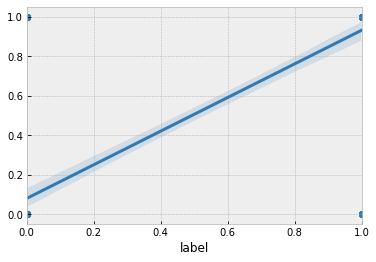

In [69]:
sns.regplot(y_test, predicted_test);

In [70]:
pred_proba_lr = [i[1] for i in gs_model_lr.predict_proba(clean_test_posts)]
pred_df_lr = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba_lr})

pred_df_lr.head()

,true_values,pred_probs
514,0,0.067360
252,1,0.641358
314,1,0.682394
368,1,0.716436
71,1,0.508425


In [71]:
lr_roc = roc_auc_score(y_test,pred_proba_lr)
lr_roc

0.971381199538639

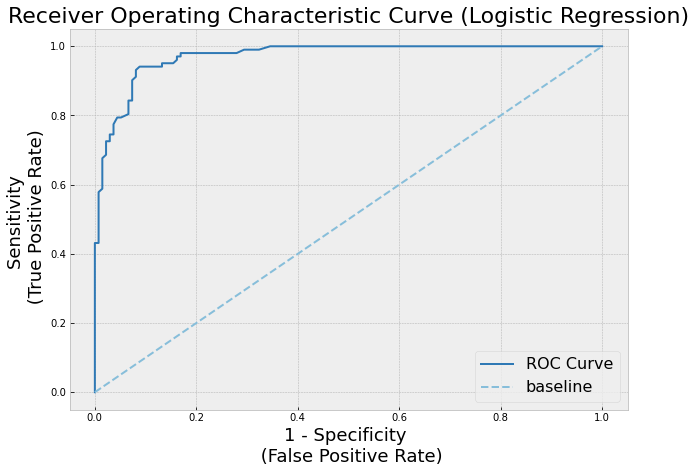

In [72]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df_lr, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df_lr, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve (Logistic Regression)', fontsize=22)
plt.ylabel('Sensitivity \n (True Positive Rate)', fontsize=18)
plt.xlabel('1 - Specificity \n (False Positive Rate)', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [73]:
gs_model_lr.steps

[('tvec', TfidfVectorizer(max_df=0.9, max_features=2500, min_df=6)),
 ('lr', LogisticRegression())]

In [74]:
words = list(gs_model_lr.steps[0][1].get_feature_names())
coeff = list(np.exp(gs_model_lr.steps[1][1].coef_[0]))

In [75]:
dataframe = pd.DataFrame(data=words)
dataframe['coef'] = coeff
dataframe.columns = ['word', 'coef']

In [76]:
dataframe.sort_values(by='coef')

,word,coef
1004,stori,0.027445
154,charact,0.052935
125,book,0.102798
692,novel,0.119583
153,chapter,0.174134
...,...,...
202,content,8.799020
1138,websit,11.585256
73,articl,12.530748
950,site,14.641411


In [77]:
lr_blog_df = dataframe.sort_values(by='coef',ascending=False).head(15)
lr_write_df = dataframe.sort_values(by='coef',ascending=False).tail(15)

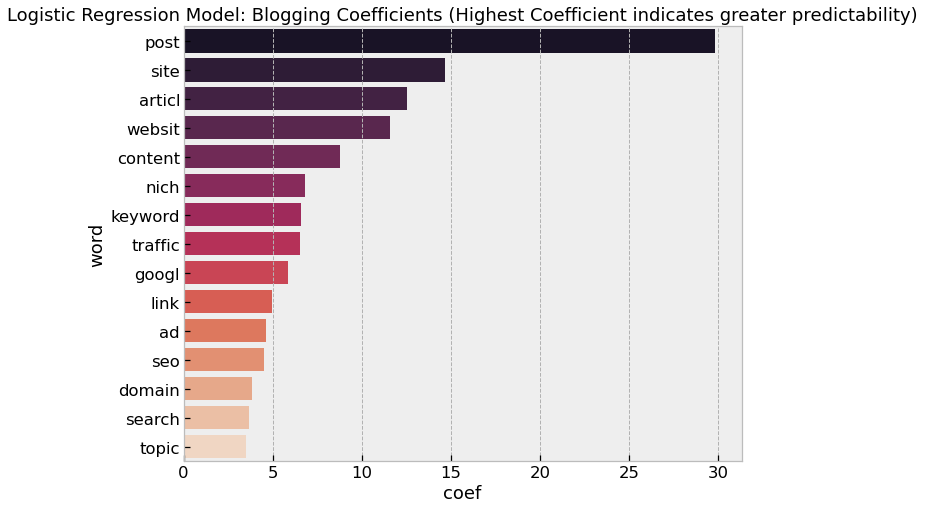

In [78]:
plt.figure(figsize=(10,8))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})
sns.barplot(data=lr_blog_df,y='word',x='coef',palette="rocket")
plt.title("Logistic Regression Model: Blogging Coefficients (Highest Coefficient indicates greater predictability)");

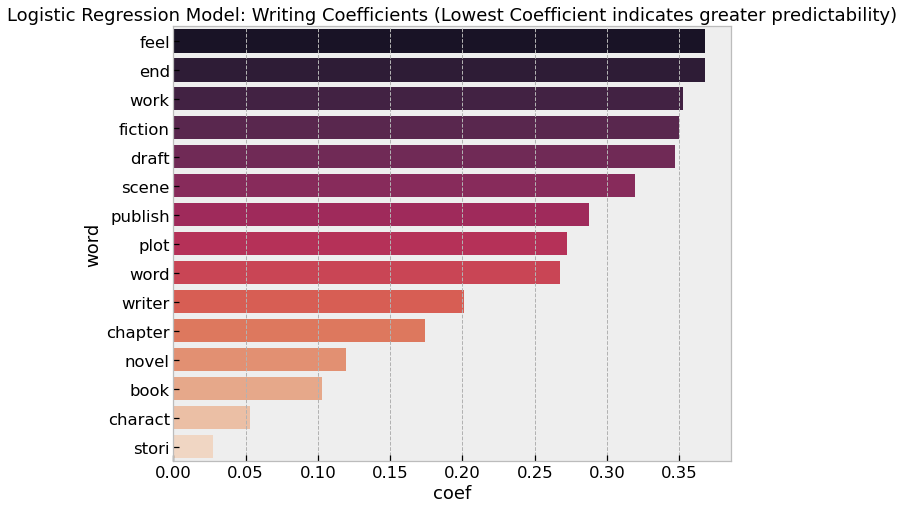

In [79]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})
plt.figure(figsize=(10,8))
sns.barplot(data=lr_write_df,y='word',x='coef',palette="rocket")
plt.title("Logistic Regression Model: Writing Coefficients (Lowest Coefficient indicates greater predictability)");

In [80]:
# Generate a confusion matrix.
cm_lr = confusion_matrix(y_test, predicted_test)

In [81]:
tn, fp, fn, tp = confusion_matrix(y_test, predicted_test).ravel()

In [82]:
cm_df = pd.DataFrame(cm_lr, columns=['predicted writing', 'predicted blogging'], index=['actual writing', 'actual blogging'])
cm_df

,predicted writing,predicted blogging
actual writing,125,11
actual blogging,7,95


#### Naive-Bayes Modelling 

In [83]:
# Import our model
from sklearn.naive_bayes import MultinomialNB

In [84]:
# Instantiate our model

nb = MultinomialNB(class_prior=[0.4,0.6])

In [87]:
# Fit our model

model = nb.fit(train_data_features_tvec, y_train)

In [88]:
# Generate our predictions

predictions = nb.predict(test_data_features_tvec)
predictions

array([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1], dtype=int64)

In [89]:
# Score our model on the training set.
nb.score(train_data_features_tvec, y_train)

0.9800210304942166

In [90]:
# Score our model on the testing set.
nb.score(test_data_features_tvec,y_test)

0.8865546218487395

In [91]:
# Generate a confusion matrix.
confusion_matrix(y_test,predictions)

array([[114,  22],
       [  5,  97]], dtype=int64)

In [92]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [93]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 114
False Positives: 22
False Negatives: 5
True Positives: 97


#### Observations

Confusion matrix suggest that our classifier is generally accurate in predicting our reddit posts into its two correct subreddit groups

#### GridSearch 

In [94]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [95]:
cross_val_score(pipe, clean_train_posts, y_train, cv=5).mean()

0.9190961697437311

In [96]:
pipe_params = {
    'tvec__max_features': [500,1000,2500],
    'tvec__min_df' : [2,4,6],
    'tvec__max_df': [0.9, 0.925, 0.95],
    'tvec__ngram_range': [(1,1),(1,2),(2,3)]}

In [97]:
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [98]:
gs.fit(clean_train_posts, y_train);

In [99]:
gs.best_score_

0.9285367869936622

In [100]:
gs.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 1000,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [101]:
gs_model_nb = gs.best_estimator_
gs_model_nb

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, max_features=1000, min_df=2,
                                 ngram_range=(1, 2))),
                ('nb', MultinomialNB())])

In [102]:
gs_model_nb.score(clean_train_posts, y_train)

0.9663512092534174

In [103]:
gs_model_nb.score(clean_test_posts, y_test)

0.9033613445378151

In [104]:
predicted_test = gs_model_nb.predict(clean_test_posts)

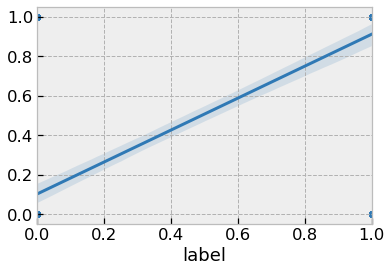

In [105]:
sns.regplot(y_test, predicted_test);

In [106]:
pred_proba_nb= [i[1] for i in gs_model_nb.predict_proba(clean_test_posts)]
pred_df_nb = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba_nb})

pred_df_nb.head()

,true_values,pred_probs
514,0,0.058846
252,1,0.775834
314,1,0.832743
368,1,0.719455
71,1,0.630669


In [107]:
nb_roc = roc_auc_score(y_test,pred_proba_nb)
nb_roc

0.9715974625144175

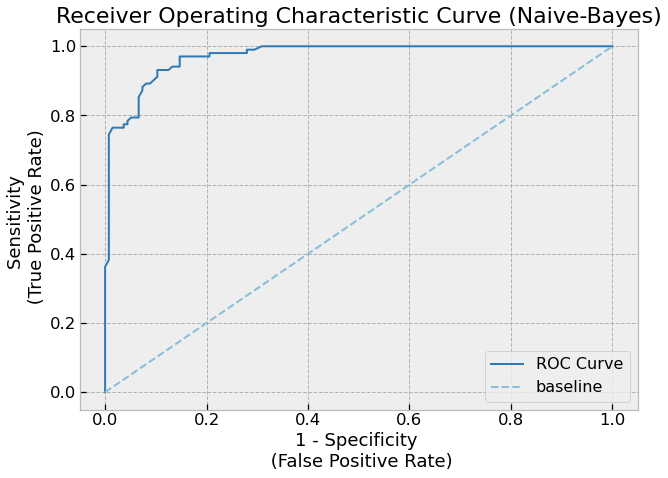

In [108]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df_nb, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df_nb, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve (Naive-Bayes)', fontsize=22)
plt.ylabel('Sensitivity \n (True Positive Rate)', fontsize=18)
plt.xlabel('1 - Specificity \n (False Positive Rate)', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [109]:
gs_model_nb.steps

[('tvec',
  TfidfVectorizer(max_df=0.9, max_features=1000, min_df=2, ngram_range=(1, 2))),
 ('nb', MultinomialNB())]

In [110]:
cm_nb = confusion_matrix(y_test, predicted_test)
tn, fp, fn, tp = cm_nb.ravel()

In [111]:
cm_df = pd.DataFrame(cm_nb, columns=['predicted writing', 'predicted blogging'], index=['actual writing', 'actual blogging'])
cm_df

,predicted writing,predicted blogging
actual writing,122,14
actual blogging,9,93


In [112]:
d = {'y_test': y_test, 'predicted_test': predicted_test,'difference':y_test-predicted_test}
nb_compare = pd.DataFrame(data=d)
nb_index_blogtowrite = nb_compare[nb_compare['difference']==1].index
nb_index_blogtowrite

Int64Index([211, 223, 488, 267, 34, 266, 164, 4, 172], dtype='int64')

In [113]:
# Misclassified from Blogging (Original) to Writing (Predicted)
df.iloc[nb_index_blogtowrite,:]['selftext'][:7]

211    I want to start a blog but need some help figuring out my niche. I want to do a book blog. The issue with this of course is that there are many book blogs so carving my corner of the market may be difficult. \n\nI feel like I know what my niche is - sort of - but I’m having trouble defining it. \n\nI want to write about the types of books I actually read, which consists of non-fiction like *Mindfuck*, Plato’s *Republic*, John Stuart Mill, Pikkety, etc. basically political science and current affairs books, including older political texts. Some of my favourite fiction includes McCarthy’s *The Road*, Williams’ *Stoner*, Atwood’s *The Handmaid’s Tale*. I like a lot of dystopian/utopian fiction but also any literary fiction that emphasises social commentary and ruminates on social/cultural/political issues. I’m not quite sure how to sum this all up; how to sell the idea of my blog in a neat and succinct way. It’s a focus on socio-political literature, fiction and non-fiction. Is tha

In [114]:
nb_index_writetoblog = nb_compare[nb_compare['difference']==-1].index
nb_index_writetoblog

Int64Index([204, 423, 396, 559, 58, 465, 47, 341, 418, 1, 4, 383, 219, 244], dtype='int64')

In [115]:
# Misclassified from Writing (Original) to Blogging (Predicted)
df.iloc[nb_index_writetoblog,:]['selftext']

204    Hello bloggers,\n\nAs you can see in the title, I'm gifting my keyword credits.\n\n&amp;#x200B;\n\n**Context**\n\nMy Keywords Everywhere credits are expiring in a month. And I have thousands of them. And I asked the mods to share some with you.\n\nSo, if you want to get keyword ideas keep reading.\n\nI will use Keywords Everywhere and KeywordFinder.io in this process to get keywords ideas.\n\nI can't promise the number of keywords, volume, and "quality". I will use the information you send me and copy the data from these tools. So, this isn't custom keyword research.\n\nI want to help as many people as possible, but I can't promise how many of you I can reply to. I estimate to be able to do this for 10-20 people.\n\n&amp;#x200B;\n\n**Here's what you can do**\n\nDM me with:\n\n* the topic of the website and be specific. You don't need to share the site name, only the topic. One example is "drone photography".\n* Send 3 to 5 keywords you already have for me to expand the list. Exa

#### Observations

Misclassified posts mainly due to short posts and ambiguous posts (it would be ambiguous after removing stopwords'

Other misclassfied posts could be due to users posting in the wrong subreddit groups

In [118]:
 def confusion(cm):
    tn, fp, fn, tp = cm.ravel()
    spec = round(tn / (tn + fp),4)
    sens = round(tp / (tp + fn),4)
    acc = round((tp+tn) / (tp+fn+tn+fp),4)
    return spec,sens,acc

In [119]:
cm_lr_array = confusion(cm_lr)
cm_nb_array = confusion(cm_nb)

In [120]:
cm_lr_array

(0.9191, 0.9314, 0.9244)

In [121]:
cm_nb_array

(0.8971, 0.9118, 0.9034)

In [122]:
cm_df_all = pd.DataFrame(cm_lr_array).T
cm_df_all.columns=['Specificity','Sensitivity','Accuracy']
cm_df_all.index=['Logistic Regression Model']
cm_nb_df = pd.DataFrame(cm_nb_array).T
cm_nb_df.columns=['Specificity','Sensitivity','Accuracy']
cm_nb_df.index=['Naive-Bayes Regression']

In [123]:
cm_df_all['ROC'] = lr_roc
cm_df_all

,Specificity,Sensitivity,Accuracy,ROC
Logistic Regression Model,0.9191,0.9314,0.9244,0.971381


In [124]:
cm_nb_df['ROC']=nb_roc
cm_nb_df

,Specificity,Sensitivity,Accuracy,ROC
Naive-Bayes Regression,0.8971,0.9118,0.9034,0.971597


#### Summarizing the Models 

In [125]:
%%html
<style>
table {float:left}
</style>

In [126]:
cm_df_all.append(cm_nb_df)

,Specificity,Sensitivity,Accuracy,ROC
Logistic Regression Model,0.9191,0.9314,0.9244,0.971381
Naive-Bayes Regression,0.8971,0.9118,0.9034,0.971597


#### Observation 

For Logistic Regression and Naive-Bayes model, both models performed largely the same in accuracy.

In terms of performance for model predictability, both also performed largely the same, though Logistic Regression has a marginally higher score.

Both models are overfitted, but this is due to the nature of our Natural Language Processing experiment.

Naives Bayes model is lower than Logistic Regression model for Specificity metric.

However, Logistic Regression performed better in terms of Sensitivity metric.

### Random Model testing 

In [127]:
str_list = []
def test_text(text):
    text = str(text)
    str_list.append(text)
    return str_list

In [128]:
# Random post from Writing subreddit
s1 = "I am having a very hard time managing my writings lately. No, it's not like I don't know how to show or not to tell; but it is the amount I want to show and not tell.My previous writings were first-person POV like most of the beginners. It is extremely easy to fill all those showing parts describing characters' gestures, thoughts, or even monologues. It was extremely easy to immerse the reader into the plot. Well, it was in my case at least.Now, I am writing a third-person limited POV cause I got fascinated by the writings of George RR Martin. The way he juggled between different characters' perspectives, the shift of attention to the very next character was beautiful and frightening at the same time. For those who do not know what is third-person limited POV, it is the third-person POV but you get to see from the POV of a single character in a scene, which is quite different from omniscient where you get to know all the character and plot at the same time.Back to my problem, I don't know whether I should tell what the character (in light) thinks, or simply show the gestures and dialogues. Should I include any monologues or not, I am even having a hard time making the settings more serious and give it more weight. What should I do?"
test_text(s1)

# Random post from Writing subreddit
s2 = "Agh I’ve always struggled with adding description in to my pieces of writing, like I know I need to add them, but I just never seem to write them! Most of my scenes will end up filled with short sentences describing mostly actions and thoughts but nothing else! Does anyone know any tips or advice on how to make sure you’re adding enough description/how to add description Anything would be appreciated!!! :)"
test_text(s2)

# Random post from Blogging subreddit
s3 = "I know it is impossible to get rid of copycats, and we all borrow information from someone else's work here and there, so none of us is entirely innocent.But how do you deal with situations in which you spend hours, if not days, to do research, verify the validity of the information you plan to claim/provide, research on keywords, write your articles carefully, do editing, etc. just to find out a few minutes after you post your work that someone else has simply copy-pasted yours to theirs? Some copycats do put in some work by paraphrasing the text to avoid Google's ranking penalties, but even so, having all the information available for you to paraphrase takes a lot less time and effort than doing the work yourself."
test_text(s3)

# Random post from Blogging subreddit
s4 = "Hello, we made it to month two of my second site. I am noticing a bit of traction both in terms of organic impressions as well as a few clicks. I've also been lucky to make a few sales already but that is because of my posting on Reddit within my niche (the group allows links if done correctly)I didn't make any money this month, but I did make 2 sales on the very last day. However, I won't get commission until the item ships so that will be in next month's report. I think it will probably be a couple of dollars."
test_text(s4)

# My test post: It should be classified as blogging.
s5 = "I am currently starting a blog on Cooking, sharing recipes about Korean cuisine with the public. I am very inspired by maangchi and her success. However, I have really bad english and I have trouble writing, and I am afraid that it will tarnish the reputation for my blog. Do you have any tips on how to write better? Do you think writing is important to the success of my blog? How do you think I can better promote and monetise my blog? Thank you."
test_text(s5)

# My test post: Similar as before but modified.
s6 = 'Hello everyone, I am currently starting a Blog dedicated to teaching the mass about Korean Cuisine. My main inspiration was from Maangchi. I would like to hear from everyone regarding tips and tricks to promote my blog, and monetise it as well. Currently, my blog has very low traffic (about 2 per day on average). I hope to hear from everyone how you optimise the search engine and promote your blog. Also, I hope to hear from you regarding writing styles. I am a native Korean who is not strong in English. Do you think it will have a negative impact on my blog?'
test_text(s6)

# Another trial text.
s7 = 'Hey all, I am starting a blog to write about marketing technology. May I learn of writing techniques where I will be able to capture the eyes of my audience in seconds? What would be eye catching? I also have issues with starting my content in the body text, and I am unsure how to maximise SEO by crafting my title smartly. Please help, thanks'
test_text(s7)
len(str_list)

7

In [129]:
test_text_predict_lr = gs_model_lr.predict(str_list)
test_text_predict_lr

array([0, 0, 0, 1, 0, 1, 1], dtype=int64)

In [130]:
test_text_predict_nb = gs_model_nb.predict(str_list)
test_text_predict_nb

array([0, 0, 1, 1, 0, 1, 1], dtype=int64)

In [131]:
true_label = list([0,0,1,1,1,1,1])
pd.DataFrame({'Text' : str_list,
              'True Label' : true_label,
              'Predicted Label (LR)' : test_text_predict_lr,
             'Predicted Label (NB)':test_text_predict_nb }, 
                                columns=['Text','True Label', 'Predicted Label (LR)','Predicted Label (NB)'])

,Text,True Label,Predicted Label (LR),Predicted Label (NB)
0,"I am having a very hard time managing my writings lately. No, it's not like I don't know how to show or not to tell; but it is the amount I want to show and not tell.My previous writings were first-person POV like most of the beginners. It is extremely easy to fill all those showing parts describing characters' gestures, thoughts, or even monologues. It was extremely easy to immerse the reader into the plot. Well, it was in my case at least.Now, I am writing a third-person limited POV cause I got fascinated by the writings of George RR Martin. The way he juggled between different characters' perspectives, the shift of attention to the very next character was beautiful and frightening at the same time. For those who do not know what is third-person limited POV, it is the third-person POV but you get to see from the POV of a single character in a scene, which is quite different from omniscient where you get to know all the character and plot at the same time.Back to my problem, I don't know whether I should tell what the character (in light) thinks, or simply show the gestures and dialogues. Should I include any monologues or not, I am even having a hard time making the settings more serious and give it more weight. What should I do?",0,0,0
1,"Agh I’ve always struggled with adding description in to my pieces of writing, like I know I need to add them, but I just never seem to write them! Most of my scenes will end up filled with short sentences describing mostly actions and thoughts but nothing else! Does anyone know any tips or advice on how to make sure you’re adding enough description/how to add description Anything would be appreciated!!! :)",0,0,0
2,"I know it is impossible to get rid of copycats, and we all borrow information from someone else's work here and there, so none of us is entirely innocent.But how do you deal with situations in which you spend hours, if not days, to do research, verify the validity of the information you plan to claim/provide, research on keywords, write your articles carefully, do editing, etc. just to find out a few minutes after you post your work that someone else has simply copy-pasted yours to theirs? Some copycats do put in some work by paraphrasing the text to avoid Google's ranking penalties, but even so, having all the information available for you to paraphrase takes a lot less time and effort than doing the work yourself.",1,0,1
3,"Hello, we made it to month two of my second site. I am noticing a bit of traction both in terms of organic impressions as well as a few clicks. I've also been lucky to make a few sales already but that is because of my posting on Reddit within my niche (the group allows links if done correctly)I didn't make any money this month, but I did make 2 sales on the very last day. However, I won't get commission until the item ships so that will be in next month's report. I think it will probably be a couple of dollars.",1,1,1
4,"I am currently starting a blog on Cooking, sharing recipes about Korean cuisine with the public. I am very inspired by maangchi and her success. However, I have really bad english and I have trouble writing, and I am afraid that it will tarnish the reputation for my blog. Do you have any tips on how to write better? Do you think writing is important to the success of my blog? How do you think I can better promote and monetise my blog? Thank you.",1,0,0
5,"Hello everyone, I am currently starting a Blog dedicated to teaching the mass about Korean Cuisine. My main inspiration was from Maangchi. I would like to hear from everyone regarding tips and tricks to promote my blog, and monetise it as well. Currently, my blog has very low traffic (about 2 per day on average). I hope to hear from everyone how you optimise the search engine and promote your blog. Also, I hope to hear from you regarding writing styles. I am a native Korean who is not strong in English. Do you think it will ha

### Conclusion
In conclusion, we are rather indifferent about both the Naive Bayes model or the Logistic Regression model in classifying our subreddit posts.

Both models have achieved a similar accuracy scores, despite having differences in other metrics that we have identified.
ROC curve also shown that Naive-Bayes and Logistic Regression is largely similar in performance.

### Limitations
As I could only scrape approximately 500-600 posts per subreddit, I believe our model could be more accurate if we increase the number of posts in our training dataset so that the model can learn more through existing data. This has certainly inhibited part of the success of our model.

### Other useful information
Overall sentiments for the Writing subreddit tend to be slightly lower than Blogging subreddit. However, both subreddit has a positive sentiment to it.

This could be attributed to the level of 'professionalism' displayed in the Blogging subreddit. On the other hand, the Written subreddit appears to be a community where writers post about their struggles and seek help. Hence, this could have pulled down our overall sentiment for Written subreddit.